In [1]:
import numpy as np
import pandas as pd
from biom import Table
from biom import Table
import qiime2 as q2

from birdman_jr.data_driven import (dirichlet_multinomial, negative_binomial,
                                    poisson_lognormal, simulate)
from birdman_jr.generators import blocks, gradient

import qiime2 as q2
from qiime2.plugins.gemelli.actions import phylogenetic_rpca_without_taxonomy, rpca
from qiime2.plugins.empress.actions import tree_plot

from skbio import DistanceMatrix, TreeNode, OrdinationResults
from skbio.stats.distance import permanova
from skbio.stats.composition import clr, closure

from gneiss.util import match
from gneiss.cluster._pba import correlation_linkage, gradient_linkage
from gneiss.sort import gradient_sort, mean_niche_estimator
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# plotting
import colorsys
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
%matplotlib inline

In [2]:
in_biom = '../../data/EMP2/emp500_woltka_classify_norm.qza'
in_meta = '../../data/EMP2/13114_20201215-131447.txt'
in_tree = '../../data/EMP2/wol_tree.qza'

table = q2.Artifact.load(in_biom)
tree = q2.Artifact.load(in_tree)

mf = pd.read_table(in_meta, index_col=0)
mf = mf[mf.empo_1.isin(['Free-living','Host-associated'])]
#mf = mf[mf.empo_2.isin(['Animal','Saline','Non-saline'])]
mf = mf[mf.empo_2.isin(['Animal','Saline','Non-saline'])]

#mf = mf[mf.empo_3.isin(['Animal distal gut','Water (saline)'])]
mf = mf[~mf.empo_3.isin(['Sediment (non-saline)','Sediment (saline)','Surface (saline)','Subsurface (non-saline)'])]



mf = mf[mf.host_taxid.isin(['447135','not applicable','None'])]

# keep shared IDs
bt = table.view(Table)
shared_ = set(bt.ids()) & set(mf.index)
bt = bt.filter(shared_)
mf = mf.reindex(shared_)
metadata = q2.Metadata(mf)

# filter out zero sums
n_features, n_samples = bt.shape
# filter features by N samples presence
min_feature_frequency = 10
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
min_feature_count = 10
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
bt = bt.filter(observation_filter, axis='observation')
#bt = bt.filter(bt.ids('observation')[(bt.sum('observation') > 0)], axis='observation')
bt = bt.filter(frequency_filter, axis='observation')
bt = bt.filter(bt.ids()[(bt.sum('sample') > 0)])

# re-import
table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
bt


3652 x 400 <class 'biom.table.Table'> with 340880 nonzero entries (23% dense)

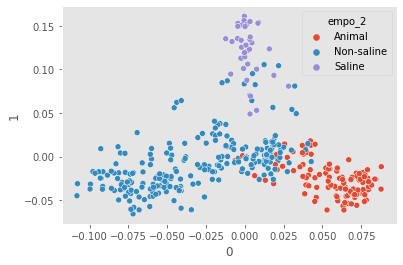

In [8]:
emp_500_prpca_res = phylogenetic_rpca_without_taxonomy(table, tree, min_feature_frequency=10)
splot = pd.concat([emp_500_prpca_res.biplot.view(OrdinationResults).samples, mf], axis=1)

sns.scatterplot(x=0, y=1, hue='empo_2', data=splot)
plt.show()
mf_sub_use = pd.concat([splot.sort_values(0).iloc[:39, :],
                        splot.sort_values(0).iloc[-39:, :],
                        splot[splot.empo_2 == 'Saline']],
                        axis=0)

bt_tmp = table.view(Table).filter(set(mf_sub_use.index) & set(table.view(Table).ids()))
table_tmp_sub = q2.Artifact.import_data('FeatureTable[Frequency]', bt_tmp)


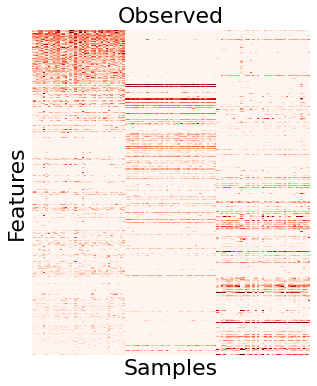

In [9]:
#bt_tmp = table.view(Table).filter(set(mf.index) & set(table.view(Table).ids()))
#table_tmp_sub = q2.Artifact.import_data('FeatureTable[Frequency]', bt_tmp)

table_block = table_tmp_sub.view(Table).to_dataframe().copy()

fload = emp_500_rpca_res.biplot.view(OrdinationResults).features
fload = fload.loc[set(table_block.index) & set(fload.index), :].sort_values(0)
order_emp = {k:i for i, k in enumerate(['Saline', 'Animal', 'Non-saline'][::-1])}
mf['sortthis'] = [order_emp[v] for v in mf.empo_2]
table_block = table_block.loc[fload.index, mf.sort_values('sortthis').index]
table_block = table_block.dropna(axis=1).dropna(axis=0)
#table_block = table_block.iloc[:-50, :]

# plot the blocks
fig, ax = plt.subplots(1,1, figsize=(5, 6))

ax.imshow(clr(table_block.T + 1).T, cmap='Reds', aspect='auto', interpolation='nearest', vmin=1e-12, vmax=8)

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Observed',
                  color='black',
                  fontsize=22)
ax.set_ylabel('Features',
                  color='black',
                  fontsize=22)
ax.set_xlabel('Samples',
                  color='black',
                  fontsize=22)
plt.show()

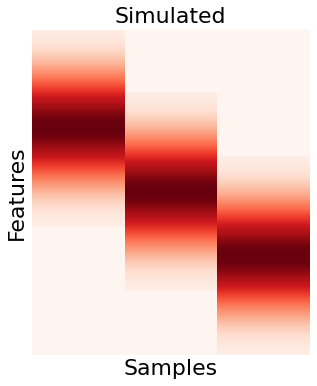

In [10]:
block_sim = blocks(3652, 401, 3, sigma=2, overlap=1000, minval=0, maxval=10000)
block_sim = block_sim[::-1, ::-1]


fig, ax = plt.subplots(1,1, figsize=(5, 6))

ax.imshow(block_sim.T, cmap='Reds', aspect='auto', interpolation='nearest')


plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Simulated',
                  color='black',
                  fontsize=22)
ax.set_ylabel('Features',
                  color='black',
                  fontsize=22)
ax.set_xlabel('Samples',
                  color='black',
                  fontsize=22)
plt.show()

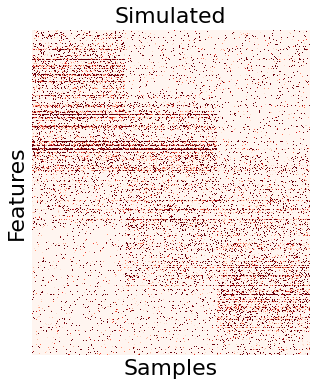

In [11]:
post_order_tips = [node.name for node in tree.view(TreeNode).postorder() if node.name in table_block.index]
block_sim_df = pd.DataFrame(block_sim.T, post_order_tips, mf.sort_values('empo_2').index)
#block_sim_df = pd.DataFrame(table_block.T, post_order_tips, mf.sort_values('empo_2').index)
block_sim_bt = Table(block_sim_df.values.T, block_sim_df.columns, block_sim_df.index)
bt_sim = simulate(block_sim_bt,
                          block_sim_bt.sum('sample').reshape(block_sim_bt.shape[1], -1) * 100,
                          distribution='pln', impose_noise=True,
                          percent_normal=0.5, percent_random=0.5, random_count=8)


fig, ax = plt.subplots(1,1, figsize=(5, 6))

ax.imshow(bt_sim.to_dataframe().T, cmap='Reds', aspect='auto', interpolation='nearest', vmax=8)


plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='both', length=0)

ax.set_title('Simulated',
                  color='black',
                  fontsize=22)
ax.set_ylabel('Features',
                  color='black',
                  fontsize=22)
ax.set_xlabel('Samples',
                  color='black',
                  fontsize=22)
plt.show()

In [12]:
post_order_tips = [node.name for node in tree.view(TreeNode).postorder() if node.name in table_block.index]
block_sim_df = pd.DataFrame(block_sim.T, post_order_tips, mf.sort_values('empo_2').index)
#block_sim_df = pd.DataFrame(table_block.T, post_order_tips, mf.sort_values('empo_2').index)
block_sim_bt = Table(block_sim_df.values, block_sim_df.index, block_sim_df.columns)

read_depth_model = {2000000:0.91371, 500000:0.2289, 200000:0.091371,
                    20000:0.0091371, 2000:0.00091371, 200:0.000091371}
#read_depth_model = {200:0.000091371}
read_depth_model_tables = {}
depth_fold = 10

for read_depth, factor in read_depth_model.items():
    
    for d_i in range(depth_fold):

        bt_sim = simulate(block_sim_bt,
                          block_sim_bt.sum('sample').reshape(block_sim_bt.shape[1], -1) * factor,
                          distribution='pln', impose_noise=True,
                          percent_normal=0.5, percent_random=0.5, random_count=6)
        read_depth_model_tables[(read_depth, d_i)] = bt_sim


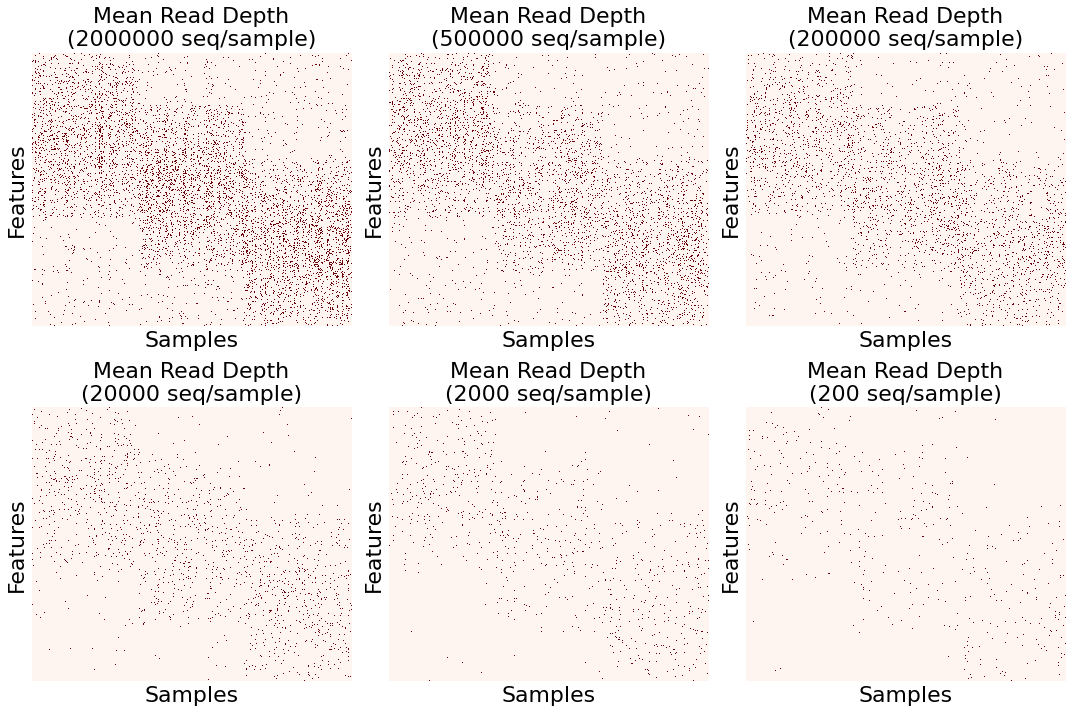

In [13]:
fig, axn = plt.subplots(2, 3, figsize=(15, 10))

d_i = 0

for depth, ax in zip(read_depth_model.keys(), axn.flatten()):
    
    table_tmp = read_depth_model_tables[(depth, d_i)]
    
    ax.imshow(table_tmp.to_dataframe(), cmap='Reds', aspect='auto', vmax=1, interpolation='nearest')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

    ax.set_title('Mean Read Depth\n(%i seq/sample)' % (depth),
                      color='black',
                      fontsize=22)
    ax.set_ylabel('Features',
                      color='black',
                      fontsize=22)
    ax.set_xlabel('Samples',
                      color='black',
                      fontsize=22)    

plt.tight_layout()
plt.savefig('../../results/figures/simulation-heatmap.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()

In [14]:
mf_sim = pd.DataFrame(['e0', 'e0'] + ['e%i' % i for i in range(3)
                                      for j in range(bt_sim.shape[1]//3)],
                      bt_sim.ids(), ['labels'])
mf_sim.head(5)


,labels
13114.mousseau.88.s014,e0
13114.mousseau.88.s022,e0
13114.sandin.54.s012,e0
13114.mousseau.88.s026,e0
13114.mousseau.88.s102,e0


In [15]:
import random
from tqdm.notebook import tqdm

final_tree_shuffles = {}
tree_shuffle = tree.view(TreeNode).deepcopy()
rndm = lambda items: random.shuffle(items)
tip_names = [n.name for n in tree_shuffle.tips()]
total_perc = {perc:int(perc * len(tip_names)) for perc in [0.0, 0.25, 0.5, 0.75, 1]}
n_shuffles = 1
n_draws = 1

for perc_, n_use in tqdm(total_perc.items()):
    
    for fold_i in range(n_draws):
        
        random_tips_use = random.sample(tip_names, n_use)

        tree_shuffle = tree.view(TreeNode).deepcopy()
        shuffler = tree_shuffle.shuffle(names=random_tips_use,
                                        shuffle_f=rndm, n=n_shuffles)
        
        for tree_i, tree_tmp in enumerate(shuffler):

            tree_tmp = q2.Artifact.import_data('Phylogeny[Rooted]',
                                               tree_tmp.deepcopy())
            
            for (read_depth, d_i), table_tmp_depth in read_depth_model_tables.items():

                table_sim = q2.Artifact.import_data('FeatureTable[Frequency]', table_tmp_depth)
                emp_500_prpca_res_tmp = phylogenetic_rpca_without_taxonomy(table_sim, tree_tmp)
                final_tree_shuffles[(read_depth, perc_, fold_i, tree_i, d_i)] = [table_sim,
                                                                                    tree_tmp,
                                                                                    emp_500_prpca_res_tmp]



  0%|          | 0/5 [00:00<?, ?it/s]

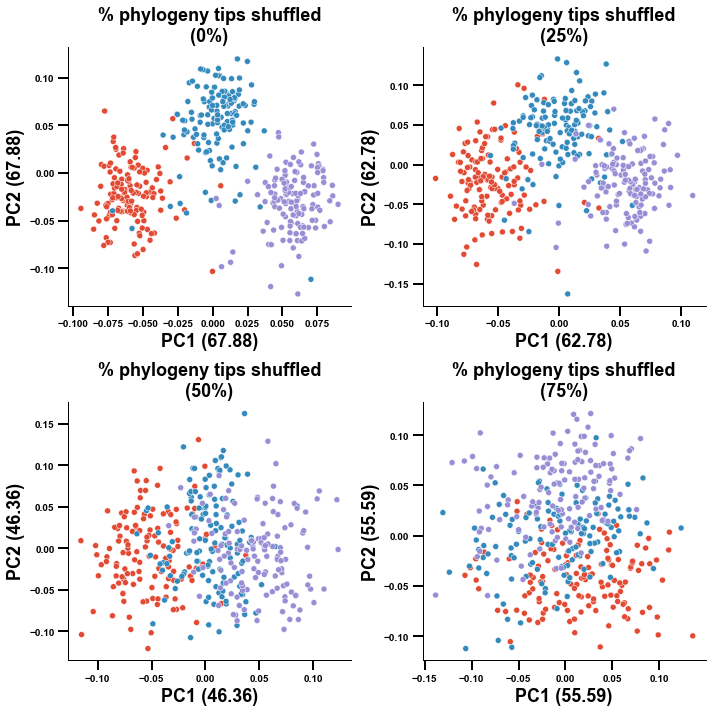

In [16]:

fig, axn = plt.subplots(2 , 2, figsize=(10, 10))

for pshuffle, ax in zip([0.0, 0.25, 0.5, 0.75], axn.flatten()):

    _, _, res_tmp = final_tree_shuffles[(500000, pshuffle, 0, 0, 0)] 
    splot = pd.concat([res_tmp.biplot.view(OrdinationResults).samples, mf_sim], axis=1)
    sns.scatterplot(x=0, y=1, hue='labels', data=splot, ax=ax)

    
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=2, length=10)
    ax.tick_params(axis='x', colors='black', width=2, length=10)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(10)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(10)
    ax.set_xlabel('PC1 (%.2f)' % (res_tmp.biplot.view(OrdinationResults).proportion_explained[0] * 100),
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_ylabel('PC2 (%.2f)' % (res_tmp.biplot.view(OrdinationResults).proportion_explained[0] * 100),
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_title('%% phylogeny tips shuffled\n(%.0f%%)' % (pshuffle * 100),
                  fontsize=18,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.legend_.remove()
    

plt.tight_layout()
plt.savefig('../../results/figures/simulation-ords.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()



In [271]:
table_sim = q2.Artifact.import_data('FeatureTable[Frequency]', read_depth_model_tables[(2000000, 0)])
emp_500_sim_prpca_res = phylogenetic_rpca_without_taxonomy(table_sim, tree)
fload = emp_500_sim_prpca_res.biplot.view(OrdinationResults).features
fload.index.name = 'featureid'
pexp = emp_500_sim_prpca_res.biplot.view(OrdinationResults).proportion_explained.values
fload.columns = ['PC%i (%.2f)' % (i, p) for i, p in enumerate(pexp)]
fload = q2.Metadata(fload)

tree_plot(emp_500_sim_prpca_res.counts_by_node_tree, fload).visualization.save('../../results/simulations/tree-example.qza')


'../../results/simulations/tree-example.qza.qzv'

In [272]:
emp_500_sim_prpca_res = phylogenetic_rpca_without_taxonomy(final_tree_shuffles[(2000000, 0.5, 0, 0, 0)][0],
                                                           final_tree_shuffles[(2000000, 0.5, 0, 0, 0)][1])
fload = emp_500_sim_prpca_res.biplot.view(OrdinationResults).features
fload.index.name = 'featureid'
pexp = emp_500_sim_prpca_res.biplot.view(OrdinationResults).proportion_explained.values
fload.columns = ['PC%i (%.2f)' % (i, p) for i, p in enumerate(pexp)]
fload = q2.Metadata(fload)

tree_plot(emp_500_sim_prpca_res.counts_by_node_tree, fload).visualization.save('../../results/simulations/medium-tree-example.qza')


'../../results/simulations/medium-tree-example.qza.qzv'

In [273]:
emp_500_sim_prpca_res = phylogenetic_rpca_without_taxonomy(final_tree_shuffles[(2000000, 1, 0, 0, 0)][0],
                                                           final_tree_shuffles[(2000000, 1, 0, 0, 0)][1])
fload = emp_500_sim_prpca_res.biplot.view(OrdinationResults).features
fload.index.name = 'featureid'
pexp = emp_500_sim_prpca_res.biplot.view(OrdinationResults).proportion_explained.values
fload.columns = ['PC%i (%.2f)' % (i, p) for i, p in enumerate(pexp)]
fload = q2.Metadata(fload)

tree_plot(emp_500_sim_prpca_res.counts_by_node_tree, fload).visualization.save('../../results/simulations/bad-tree-example.qza')


'../../results/simulations/bad-tree-example.qza.qzv'

In [274]:
final_tree_shuffles_no_tree = {}

for sim_char, (table_tmp, _, _) in tqdm(final_tree_shuffles.items()):
    
    read_depth, perc_, fold_i, tree_i, d_i = sim_char
    
    if (perc_ == 1) & (fold_i == 0) & (tree_i == 0):
        no_tree_tmp = rpca(table_tmp)
        final_tree_shuffles_no_tree[(read_depth, 'no-phylogeny',
                                     fold_i, tree_i, d_i)] = [table_tmp, 'none', no_tree_tmp]
        
    

  0%|          | 0/300 [00:00<?, ?it/s]

In [275]:
# add both results
final_tree_shuffles_both = {**final_tree_shuffles_no_tree, **final_tree_shuffles}


In [276]:
ml_results = {}
catagory = 'labels'

for sim_char, (_, _, res_tmp) in final_tree_shuffles_both.items(): 

    ord_ = res_tmp.biplot.view(OrdinationResults)
    ord_tmp = ord_.samples[[0, 1]].copy()
    #mf_tmp = metadata.to_dataframe().copy().reindex(ord_tmp.index)
    mf_tmp = mf_sim.reindex(ord_tmp.index)
    ord_tmp = pd.concat([ord_tmp, mf_tmp[list(set([catagory]))]],
                        axis=1, sort=False).dropna(subset=[0, catagory])
    ord_tmp[catagory] = ord_tmp[catagory].astype(str)
    X = ord_tmp[[0, 1]].values
    sids = ord_tmp.index
    classes_ = list(set(ord_tmp[catagory].values.ravel()))
    y = label_binarize(ord_tmp[catagory].values.ravel(), classes=classes_)
    # instantiate the grid
    sss = StratifiedShuffleSplit(n_splits=10,
                                 test_size=0.5,
                                 random_state=42)
    sss.get_n_splits(X, y)

    # for each split run classifier
    for fold, (train_index, test_index) in enumerate(sss.split(X, y.argmax(1))):
        # split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # predict
        classifier = KNeighborsClassifier(n_neighbors=40)
        model_tmp = classifier.fit(X_train, y_train)
        y_score = model_tmp.predict_proba(X_test)
        y_score = np.vstack([y_score_class[:, 1] for y_score_class in y_score]).T
        avergage_roc_auc = roc_auc_score(y_test, y_score, average='macro')
        avergage_aps_auc = average_precision_score(y_test, y_score)   
        ml_results[(sim_char[0],
                    sim_char[1],
                    sim_char[2],
                    sim_char[3],
                    sim_char[4], fold, 'PR-AUC')] = [avergage_aps_auc]
        ml_results[(sim_char[0],
                    sim_char[1],
                    sim_char[2],
                    sim_char[3],
                    sim_char[4], fold, 'ROC-AUC')] = [avergage_roc_auc]


In [277]:
perm_results = {}

for sim_char, (_, _, res_tmp) in final_tree_shuffles_both.items(): 



    dist_tmp = res_tmp.distance_matrix.view(DistanceMatrix)
    #mf_tmp_sup = mf.loc[dist_tmp.ids, list(set([catagory]))].dropna()
    mf_tmp_sup = mf_sim.loc[dist_tmp.ids, list(set([catagory]))].dropna()
    dist_tmp = dist_tmp.filter(mf_tmp_sup.index)
    permanova_tmp = permanova(dist_tmp, 
                              mf_tmp_sup.loc[dist_tmp.ids, catagory],
                              permutations=1000)
    # F-stat    
    perm_results[(sim_char[0],
                  sim_char[1],
                  sim_char[2],
                  sim_char[3],
                  sim_char[4],
                   0,
                   'PERMANOVA: F-statistic')] = [permanova_tmp['test statistic']]


In [279]:
sim_res = pd.DataFrame({**perm_results, **ml_results}).T.reset_index()
sim_res.columns = ['read depth', 'percent tips shuffles','fold tips subset',
                   'fold shuffle', 'fold depth','fold evaluation', 'metric', 'score']
sim_res.to_csv('../../results/simulations/final-results-generator.tsv', sep='\t')
sim_res.head(5)

    

,read depth,percent tips shuffles,fold tips subset,fold shuffle,fold depth,fold evaluation,metric,score
0,2000000,no-phylogeny,0,0,0,0,PERMANOVA: F-statistic,0.419502
1,2000000,no-phylogeny,0,0,1,0,PERMANOVA: F-statistic,0.782688
2,2000000,no-phylogeny,0,0,2,0,PERMANOVA: F-statistic,0.760128
3,2000000,no-phylogeny,0,0,3,0,PERMANOVA: F-statistic,0.654126
4,2000000,no-phylogeny,0,0,4,0,PERMANOVA: F-statistic,2.880797


In [268]:
sim_res[sim_res['read depth'] == 200000].groupby(['percent tips shuffles','metric']).mean()

read depth  fold tips subset  \
percent tips shuffles metric                                                 
0.25                  PERMANOVA: F-statistic    200000.0               0.0   
                      PR-AUC                    200000.0               0.0   
                      ROC-AUC                   200000.0               0.0   
0.5                   PERMANOVA: F-statistic    200000.0               0.0   
                      PR-AUC                    200000.0               0.0   
                      ROC-AUC                   200000.0               0.0   
0.75                  PERMANOVA: F-statistic    200000.0               0.0   
                      PR-AUC                    200000.0               0.0   
                      ROC-AUC                   200000.0               0.0   
1                     PERMANOVA: F-statistic    200000.0               0.0   
                      PR-AUC                    200000.0               0.0   
                      ROC-AUC                   200000.0               0.0   
no-phylogeny          PERMANOVA: F-statistic    200000.0               0.0   
                      PR-AUC                    200000.0               0.0   
                      ROC-AUC                   200000.0               0.0   

                                              fold shuffle  fold depth  \
percent tips shuffles metric                                             
0.25                  PERMANOVA: F-statistic           0.0         4.5   
                      PR-AUC                           0.0         4.5   
                      ROC-AUC                          0.0         4.5   
0.5                   PERMANOVA: F-statistic           0.0         4.5   
                      PR-AUC                           0.0         4.5   
                      ROC-AUC                          0.0         4.5   
0.75                  PERMANOVA: F-statistic           0.0         4.5   
                      PR-AUC                           0.0         4.5   
                      ROC-AUC                          0.0         4.5   
1                     PERMANOVA: F-statistic           0.0         4.5   
                      PR-AUC                           0.0         4.5   
                      ROC-AUC                          0.0         4.5   
no-phylogeny          PERMANOVA: F-statistic           0.0         4.5   
                      PR-AUC                           0.0         4.5   
                      ROC-AUC                          0.0         4.5   

                                              fold evaluation       score  
percent tips shuffles metric                                               
0.25                  PERMANOVA: F-statistic              0.0  198.327745  
                      PR-AUC                              4.5    0.908845  
                      ROC-AUC                             4.5    0.951584  
0.5                   PERMANOVA: F-statistic              0.0  109.673937  
                      PR-AUC                              4.5    0.780501  
                      ROC-AUC                             4.5    0.880748  
0.75                  PERMANOVA: F-statistic              0.0   44.938679  
                      PR-AUC                              4.5    0.583498  
                      ROC-AUC                             4.5    0.741159  
1                     PERMANOVA: F-statistic              0.0    2.356669  
                      PR-AUC                              4.5    0.353591  
                      ROC-AUC                             4.5    0.513945  
no-phylogeny          PERMANOVA: F-statistic              0.0    0.800072  
                      PR-AUC                              4.5    0.342006  
                      ROC-AUC                             4.5    0.497919